# Introduction

The notebook is a step-by-step tutorial on using Transformer models for Natural Language Inferencing (NLI). This includes how to load, fine-tune, and evaluate M-BERT and XLM-RoBERTa models with Tensorflow.

Natural Language Inferencing (NLI) is an exciting NLP (Natural Language Processing) problem to identify the semantic relationship between two sentences. Given a hypothesis and premise sentence-pairs, the task is to determine whether the premise `entails` the hypothesis statement, `contradicts` it, or neither (`neutral`). 

For more information on the problem, you can visit [Contradictory, My Dear Watson competition](https://www.kaggle.com/c/contradictory-my-dear-watson/overview)

# Load Libraries and Dependencies

In [8]:
import numpy as np 
import pandas as pd 
import os
import sys
from transformers import BertTokenizer, TFBertModel
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel, T5TokenizerFast as T5Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Handle Warnings: Optional
os.environ["WANDB_API_KEY"] = "0" # to silence warning
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices" # enable xla devices
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

np.random.seed(0) # For reproducibility

# Make sure to install the right version of Python and Tensorflow for reproducible results
print("Python version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

2022-12-05 18:01:39.908825: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-05 18:01:39.909804: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Python version: 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
Tensorflow version: 2.4.1


# Configure TPU Settings

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of Replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-12-05 18:01:48.801574: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-05 18:01:48.801650: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 18:01:48.801695: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9dc0d079ebcd): /proc/driver/nvidia/version does not exist
2022-12-05 18:01:48.806630: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 18:01:48.837687: I tensorflow/core/platform/profile_utils/cpu_util

Number of Replicas: 8


<h1>LOAD PASTA DATA</h1>

In [10]:
# Data loading

df = pd.read_csv('/kaggle/input/participant-states/pasta.csv')
df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
df.set_index('Index', inplace=True, drop=True)

print(df.shape)
# df.head()

(10743, 17)


In [11]:
# Data processing

df['line'] = df.apply(lambda row: row.line1 + ' ' + row.line2 + ' ' + row.line3 + ' ' + row.line4 + ' ' + row.line5, axis=1)
#premise1
df['mod_line'] = df.apply(lambda row: row.mod_line1 + ' ' + row.mod_line2 + ' ' + row.mod_line3 + ' ' + row.mod_line4 + ' ' + row.mod_line5, axis=1)
#premise2
df['isContrastive'] = df.apply(lambda row: 0, axis=1)

# df['line_assertion'] = df.apply(lambda row: ' [CLS] ' + row.line + ' [SEP] ' + row.assertion + ' [SEP] ', axis=1)
# df['mod_line_assertion'] = df.apply(lambda row: ' [CLS] ' + row.mod_line + ' [SEP] ' + row.assertion + ' [SEP] ', axis=1)
# df['line_mod_assertion'] = df.apply(lambda row: ' [CLS] ' + row.line + ' [SEP] ' + row.mod_assertion + ' [SEP] ', axis=1)
# df['mod_line_mod_assertion'] = df.apply(lambda row: ' [CLS] ' + row.mod_line + ' [SEP] ' + row.mod_assertion + ' [SEP] ', axis=1)

# print(df.iloc[0])
df1 = df[['line', 'assertion', 'Data type', 'isContrastive']].copy()
df1.rename({'line': 'premise', 'assertion' : 'hypothesis'}, axis=1, inplace=True)
df1['label'] = 1

df2 = df[['mod_line' , 'assertion', 'Data type', 'isContrastive']].copy()
df2.rename({'mod_line' :  'premise', 'assertion' : 'hypothesis'}, axis=1, inplace=True)
df2['label'] = 0
df['isContrastive'] = 1

df3 = df[['line', 'mod_assertion', 'Data type', 'isContrastive']].copy()
df3.rename({'line': 'premise', 'mod_assertion' : 'hypothesis'}, axis=1, inplace=True)
df3['label'] = 0

df4 = df[['mod_line' , 'mod_assertion', 'Data type', 'isContrastive']].copy()
df4.rename({'mod_line' :  'premise', 'mod_assertion' : 'hypothesis'}, axis=1, inplace=True)
df4['label'] = 1
df['isContrastive'] = 1


df_processed = pd.concat([df1, df2, df3, df4])

print(df_processed.shape)

print(df_processed[df_processed.label == 1].iloc[:2].values)
print(df_processed[df_processed.label == 0].iloc[:2].values)
df_processed.head(5)

(42972, 5)
[['Bill and Ted were best friends. They were high school students. They would eat lunch together every day. They would play with the coins they had in their pockets. They played and loved a game called quarters together.'
  'Bill and Ted were older teenagers.' 'Train' 0 1]
 ['Tina went out to eat yesterday. She ordered salmon. All the sudden she saw something. There was a bug in her plate. Tina screamed.'
  'Tina is squeamish.' 'Train' 0 1]]
[['Bill and Ted were best friends. They were kindergarten students. They would eat lunch together every day. They would play with the coins they had in their pockets. They played and loved a game called quarters together.'
  'Bill and Ted were older teenagers.' 'Train' 0 0]
 ['Tina went out to eat yesterday. She ordered salmon. All the sudden she saw something. There was a bug in her plate. Tina told the waiter calmly.'
  'Tina is squeamish.' 'Train' 0 0]]


,premise,hypothesis,Data type,isContrastive,label
Index,,,,,
0,Bill and Ted were best friends. They were high...,Bill and Ted were older teenagers.,Train,0,1
1,Tina went out to eat yesterday. She ordered sa...,Tina is squeamish.,Train,0,1
2,I was given a difficult task by my employer. I...,My boss is accommodating.,Train,0,1
3,My boss wanted me to work overtime. I refused....,The boss did not appreciate my comment.,Train,0,1
4,Anna did not wake up for school one morning. W...,Anna can hear.,Train,0,1


In [12]:
pasta_data = df_processed.copy()
pasta_data.head()

,premise,hypothesis,Data type,isContrastive,label
Index,,,,,
0,Bill and Ted were best friends. They were high...,Bill and Ted were older teenagers.,Train,0,1
1,Tina went out to eat yesterday. She ordered sa...,Tina is squeamish.,Train,0,1
2,I was given a difficult task by my employer. I...,My boss is accommodating.,Train,0,1
3,My boss wanted me to work overtime. I refused....,The boss did not appreciate my comment.,Train,0,1
4,Anna did not wake up for school one morning. W...,Anna can hear.,Train,0,1


In [69]:
# sum(np.logical_and(pasta_data['isContrastive'] == 1 , pasta_data['label'] == 0))

# Split the Training Data

We will be splitting the training dataset into two parts - the data we will train the model with and a validation set. We stratify data during train-valid split to preserve the original distribution of the target classes.

In [13]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(pasta_data, stratify=pasta_data.label.values, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)
validation, test = train_test_split(validation, stratify=validation.label.values, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)

train.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [14]:
# check the number of rows and columns after split
print("Train data: {} \n".format(train.shape))
print("Validation data: {} \n".format(validation.shape))
print("Test data: {} \n".format(test.shape))

Train data: (30080, 5) 

Validation data: (9024, 5) 

Test data: (3868, 5) 



# Implement M-BERT Model

The Multilingual BERT or M-BERT is a single language model pre-trained on the concatenation of monolingual Wikipedia corpora from 104 languages. We will fine-tune this pretrained model on our training dataset to get the predictions for textual entailment recognition.

## Set up M-BERT Tokenizer

A pretrained model only performs properly if we feed it an input that was tokenized with the same rules that were used to tokenize its training data. The BERT multilingual model does not perform any normalization on the input (no lower casing, accent stripping, or Unicode normalization). Hence we also follow the same rules when tokenizing input data for our task. For more information on data pre-processing, visit [M-BERT github](https://github.com/google-research/bert/blob/master/multilingual.md).

In [15]:
PRETRAINED_MODEL_TYPES = {}
PRETRAINED_MODEL_TYPES['bert'] = (TFBertModel, BertTokenizer, 'bert-base-multilingual-cased')
model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['bert']

tokenizer = BertTokenizer.from_pretrained(model_name) # Save the slow pretrained tokenizer
save_path = '.'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path) # Save the loaded tokenizer locally
tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=False, strip_accents=False) # Load the fast tokenizer from saved file

tokenizer

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix=##)

Let's look at the sequence length distribution (e.g. number of tokens in a sequence) for the input data. We will need this information later when setting the `max_len` value since a machine learning algorithm requires all the inputs in a batch to have the same length.

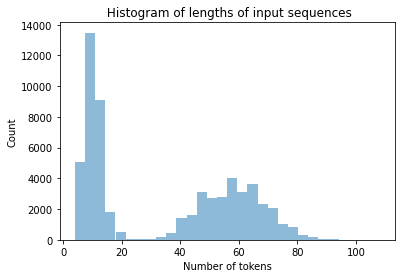

In [16]:
def plot(df, tokenizer):
    """
    Plot histogram of lengths of input sequences
    """
    all_text = df.premise.values.tolist() + df.hypothesis.values.tolist() # list of string texts
    all_text_tokenized = tokenizer.encode_batch(all_text) # list of encoding objects
    all_tokenized_len = [len(encoding.tokens) for encoding in all_text_tokenized] # list of token lengths
       
    plt.hist(all_tokenized_len, bins=30, alpha=0.5)
    plt.title(' Histogram of lengths of input sequences')
    plt.xlabel('Number of tokens')
    plt.ylabel('Count')

    plt.show()

plot(train, tokenizer)

From the histogram above, we can see that majority of the input sequences have less than 50 tokens.

We can also calculate the mean and max input sequence lengths per language.

The length should be large enough such that we don’t lose much data. Additionally, a very big number would make the model complex.

Since most of the inputs are shorter than 50 words, we can consider length 50 for each input type of hypothesis and premise. 

Hence we set `MAX_LEN`=100.

*Note*: The `MAX_LEN` hyperparameter can be taken as a parameter to be tuned to get optimal results.

## Configure Hyperparameter Settings

In [17]:
# Configuration
EPOCHS = 20
BATCH_SIZE = 64 
MAX_LEN = 100
PATIENCE = 5
LEARNING_RATE = 1e-5

## Encode Input Sequences

For BERT model, the input is represented in the following format:

`CLS` Premise `SEP` Hypothesis `SEP`

The `CLS` and `SEP` are special tokens, where `CLS` is used in the beginning of a sequence for sentence-level classification while `SEP` separates the sentence pairs.

We encode the training data by vectorizing the input strings and applying padding and truncation using `MAX_LEN` value.

The encoded input will include - input word IDs, input masks, and input type IDs

In [15]:
def encode(df, tokenizer, max_len=50):
    """
    Encode the input sequences to feed into the MBERT model. 
    Note that encode_batch() is used as 'BertWordPieceTokenizer' object has no attribute 'batch_encode_plus'
    """
    pairs = df[['premise','hypothesis']].values.tolist()

    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()
    
    print ("Encoding...")
    enc_list = tokenizer.encode_batch(pairs)
    print ("Complete")
    
    input_word_ids = tf.ragged.constant([enc.ids for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.ragged.constant([enc.attention_mask for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len]
    input_type_ids = tf.ragged.constant([enc.type_ids for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len]
   
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask.to_tensor(),
        'input_type_ids': input_type_ids.to_tensor()}
    
    return inputs 

In [16]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)
train_ids = train_input['input_word_ids'] #[9696, max_len]
train_mask = train_input['input_mask'] #[9696, max_len]
train_type = train_input['input_type_ids'] #[9696, max_len]
train_labels = train.label.values

Encoding...
Complete


In [17]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)
validation_ids = validation_input['input_word_ids'] #[num_examples, max_len]
validation_mask = validation_input['input_mask'] #[num_examples, max_len]
validation_type = validation_input['input_type_ids'] #[num_examples, max_len]
validation_labels = validation.label.values #[num_examples]

Encoding...
Complete


In [18]:
test_input = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)
test_ids = test_input['input_word_ids'] #[num_examples, max_len]
test_mask = test_input['input_mask'] #[num_examples, max_len]
test_type = test_input['input_type_ids'] #[num_examples, max_len]
test_labels = test.label.values #[num_examples]

Encoding...
Complete


## Load and Process the Data in Batches

In [18]:
def create_dataset(features, labels, batch_size=BATCH_SIZE, validation=False):
    """
    Load and process input data into batches using TF Dataset 
    """
    AUTO = tf.data.experimental.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(len(features))
    if validation:
        dataset = dataset.batch(batch_size).prefetch(AUTO)
    else:
        dataset = dataset.repeat().batch(batch_size).prefetch(AUTO)
    return dataset

In [20]:
training_data = create_dataset((train_ids, train_mask, train_type), train_labels, batch_size=BATCH_SIZE)
validation_data = create_dataset((validation_ids, validation_mask, validation_type), validation_labels, batch_size=BATCH_SIZE, validation=True)
test_data = create_dataset((test_ids, test_mask, test_type), test_labels, batch_size=BATCH_SIZE, validation=True)

## Create and Train Model

We extract the hidden state vector of the 'CLS' token in the final BERT layer and pass that as input to the classification layer for further training.

In [19]:
def build_model(model_name, model_class, max_len=50, add_input_type=False):
    """
    Define the model architecture
    """
    
    tf.random.set_seed(123) # For reproducibility
    
    # The bare XLM-RoBERTa Model transformer outputting raw hidden-states without any specific head on top.
    encoder = model_class.from_pretrained(model_name)
#     encoder = TFAutoModel.from_pretrained(model_name)
    
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    # Extract final layer feature vectors
    if add_input_type:
        features = encoder([input_word_ids, input_mask, input_type_ids])[0] # shape=(batch_size, max_len, output_size)
    else:
        features = encoder([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, output_size)
    
    # We pass the vector of only the [cls] token (at index=0) to the classification layer
    sequence = features[:,0,:] #shape=(batch_size, output_size)
   
    # Add a classification layer
    output = tf.keras.layers.Dense(2, activation="softmax")(sequence)  
    
    if add_input_type:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    else:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
        
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(model_name, model_class, MAX_LEN, add_input_type=True)
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

The model will be trained on the training subset and early-stopping will be applied on validation subset to avoid overfitting. The best model checkpoint will be saved after `EPOCHS` iterations.

In [23]:
checkpoint_filepath='bert_best_checkpoint.hdf5'
# # callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)]
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), 
    ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-12)
]

n_steps = int(train_ids.shape[0]/BATCH_SIZE)
train_history = model.fit(x=training_data, validation_data=validation_data, epochs=EPOCHS, verbose=1, steps_per_epoch=n_steps, callbacks=callbacks)

KeyboardInterrupt: 

## Plot Training and Validation Losses over all Epochs

In [20]:
def plot_loss(history):
    ''' Plot loss history '''
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Average Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
plot_loss(train_history)

NameError: name 'train_history' is not defined

## Plot Training and Validation Accuracies over all Epochs

In [21]:
def plot_acc(history):
    ''' Plot accuracy history '''
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Average Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_acc(train_history)

From the above plots, we can see that there is a huge gap between the training and validation losses, which suggests that the M-BERT model is not quite good at generalizing to unseen data. The M-BERT model gives final validation accuracy of around 64-66%. In the next section, we'll look at another model, namely XLM-RoBERTa, which improves the validation accuracy and is much better at predictions on new data.  

In [24]:
# model.predict(validation_input)
model.load_weights('/kaggle/working/bert_best_checkpoint.hdf5')

In [ ]:
# print(test_ids.shape)
# # model.evaluate(test_ids, test_mask, test_type)
# test_input['input_type_ids'].shape, test_input['input_mask'].shape, test_input['input_word_ids']

In [ ]:
# test_output = model.predict(test_input)

In [25]:
model.evaluate(test_input, test_labels)

121/121 [==============================] - 12s 20ms/step - loss: 0.6485 - accuracy: 0.6254


[0.6484770774841309, 0.6253877878189087]

In [ ]:
del model #to free up space

In [ ]:
# Resets all state generated by Keras
K.clear_session()

# Implement XLM-RoBERTa Model

The XLM-RoBERTa is based on Facebook’s RoBERTa model released in 2019. It is a large multi-lingual language model, trained on 2.5TB of filtered CommonCrawl data.

In [27]:
PRETRAINED_MODEL_TYPES['xlmroberta'] = (TFXLMRobertaModel, XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-base')
model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['xlmroberta']

# Download vocabulary from huggingface.co and cache.
# tokenizer = tokenizer_class.from_pretrained(model_name) 
tokenizer = AutoTokenizer.from_pretrained(model_name) #fast tokenizer

tokenizer

PreTrainedTokenizerFast(name_or_path='jplu/tf-xlm-roberta-base', vocab_size=250002, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [28]:
train.head()

,premise,hypothesis,Data type,label
0,Reed enjoyed playing the cello a lot. He wante...,Reed has no knack for cello.,Validation,1
1,I got fed up of having too much work on my pla...,I think my boss did not believe me.,Train,1
2,James was getting ready for Halloween night. H...,James was not brave,Validation,1
3,Jim's puppy Spot was recently found and return...,Jane was angry to see Jim sleeping on the floor.,Train,0
4,My sister in law's washer died this spring. He...,He thought the washer was expensive.,Train,1


In [29]:
def encode(df, tokenizer, max_len=50):
    """
    Encode the input sequences to feed into the XLM-Roberta model
    """
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True)
    print ("Complete")
    
    input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]
    
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask}    
    
    return inputs


In [30]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)
train_ids = train_input['input_word_ids'] #[9696, max_len]
train_mask = train_input['input_mask'] #[9696, max_len]
train_labels = train.label.values

Encoding...
Complete


In [31]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)
validation_ids = validation_input['input_word_ids'] #[num_examples, max_len]
validation_mask = validation_input['input_mask'] #[num_examples, max_len]
validation_labels = validation.label.values #[num_examples]

Encoding...
Complete


In [32]:
test_input = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)
test_ids = test_input['input_word_ids'] #[num_examples, max_len]
test_mask = test_input['input_mask'] #[num_examples, max_len]
test_labels = test.label.values #[num_examples]

Encoding...
Complete


In [33]:
training_data = create_dataset((train_ids, train_mask), train_labels, batch_size=BATCH_SIZE, validation=False)
validation_data = create_dataset((validation_ids, validation_mask), validation_labels, batch_size=BATCH_SIZE, validation=True)
test_data = create_dataset((test_ids, test_mask), test_labels, batch_size=BATCH_SIZE, validation=True)

In [34]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(model_name, model_class, MAX_LEN)
    model.summary()

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 278043648   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tfxlm_roberta_model[0][0]  

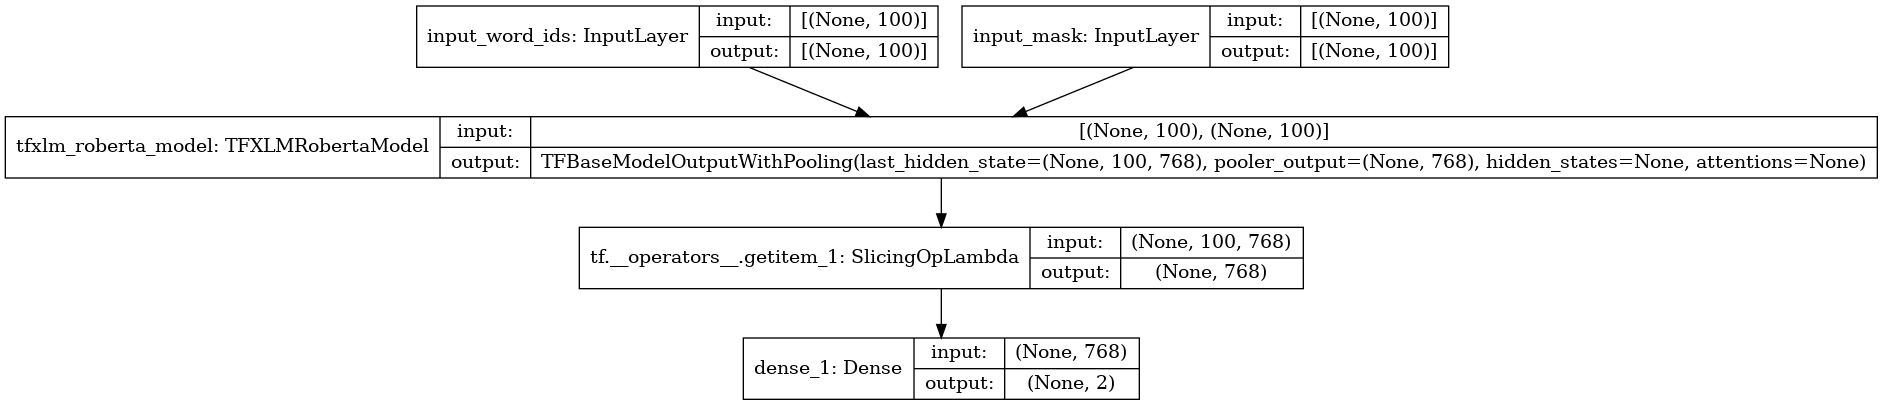

In [35]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
checkpoint_filepath='xlmroberta_best_checkpoint.hdf5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), 
    ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
#     ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=1e-12)
]

n_steps = int(train_ids.shape[0]/BATCH_SIZE)
train_history = model.fit(x=training_data, validation_data=validation_data, epochs=EPOCHS, verbose=1, steps_per_epoch=n_steps, callbacks=callbacks)

In [ ]:
plot_loss(train_history)


In [ ]:
plot_acc(train_history)


In [36]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights('/kaggle/working/xlmroberta_best_checkpoint.hdf5')


In [37]:
model.evaluate(test_input, test_labels)

121/121 [==============================] - 15s 19ms/step - loss: 0.5687 - accuracy: 0.6804


[0.5735974311828613, 0.6714063882827759]

# Implement T5 Model

## Set up the Tokenizer

In [22]:
from transformers import T5Tokenizer, TFT5Model

model_class, tokenizer_class, model_name = TFT5Model, T5Tokenizer, 't5-large'
tokenizer = T5Tokenizer.from_pretrained('t5-large')
tokenizer

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='t5-large', vocab_size=32100, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>'

## Encode Input Sequences

The encoded input will include - input word IDs and input masks, as required by the XLM-RoBERTa model.

In [23]:
# tokenizer

In [24]:
train.head()

,premise,hypothesis,Data type,isContrastive,label
0,Reed enjoyed playing the cello a lot. He wante...,Reed has no knack for cello.,Validation,1,1
1,I got fed up of having too much work on my pla...,I think my boss did not believe me.,Train,0,1
2,James was getting ready for Halloween night. H...,James was not brave,Validation,0,1
3,Jim's puppy Spot was recently found and return...,Jane was angry to see Jim sleeping on the floor.,Train,1,0
4,My sister in law's washer died this spring. He...,He thought the washer was expensive.,Train,0,1


In [25]:

def encode(df, tokenizer, max_len=50):
    """
    Encode the input sequences to feed into the XLM-Roberta model
    """
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True, return_token_type_ids=True)
    print ("Complete")
    
    input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]
    input_type_ids = tf.convert_to_tensor(encoded_dict['token_type_ids'], dtype=tf.int32) #shape=[num_examples, max_len]
    
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids' : input_type_ids
    }    
    
    return inputs

In [26]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)
train_ids = train_input['input_word_ids'] #[9696, max_len]
train_mask = train_input['input_mask'] #[9696, max_len]
train_type = train_input['input_type_ids']
train_labels = train.label.values

Encoding...
Complete


In [27]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)
validation_ids = validation_input['input_word_ids'] #[num_examples, max_len]
validation_mask = validation_input['input_mask'] #[num_examples, max_len]
validation_type = validation_input['input_type_ids']
validation_labels = validation.label.values #[num_examples]

Encoding...
Complete


In [28]:
test_input = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)
test_ids = test_input['input_word_ids'] #[num_examples, max_len]
test_mask = test_input['input_mask'] #[num_examples, max_len]
test_type = test_input['input_type_ids'] #[num_examples, max_len]
test_labels = test.label.values #[num_examples]

Encoding...
Complete


In [29]:
# train_type.shape, validation_type.shape, test_type.shape

## Load and Process Data into Batches

In [30]:
training_data = create_dataset((train_ids, train_mask, train_type), train_labels, batch_size=BATCH_SIZE, validation=False)
validation_data = create_dataset((validation_ids, validation_mask, validation_type), validation_labels, batch_size=BATCH_SIZE, validation=True)
test_data = create_dataset((test_ids, test_mask, test_type), test_labels, batch_size=BATCH_SIZE, validation=True)

## Create and Train Model

In [31]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(model_name, model_class, MAX_LEN, add_input_type=True)
    model.summary()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

2022-12-05 18:05:52.372050: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFT5Model.

All the layers of TFT5Model were initialized from the model checkpoint at t5-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5Model for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_t5model (TFT5Model)          TFSeq2SeqModelOutput 737668096   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

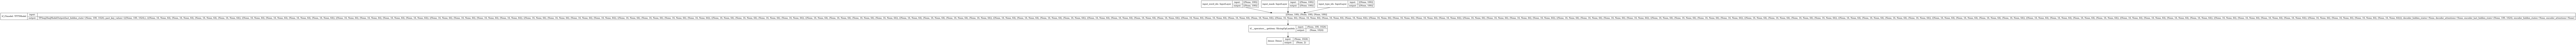

In [32]:
plot_model(model, to_file='model.png', show_shapes=True)

Let's now train the built model on training data and monitor the performance of the model on the validation data

In [33]:
checkpoint_filepath='T5_large_best_checkpoint_1.hdf5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), 
    ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-12)
]

n_steps = int(train_ids.shape[0]/BATCH_SIZE)
train_history = model.fit(x=training_data, validation_data=validation_data, epochs=EPOCHS, verbose=1, steps_per_epoch=n_steps, callbacks=callbacks)

Epoch 1/20
470/470 [==============================] - 484s 445ms/step - loss: 0.7326 - accuracy: 0.5092 - val_loss: 0.6926 - val_accuracy: 0.5137

Epoch 00001: val_loss improved from inf to 0.69259, saving model to T5_large_best_checkpoint_1.hdf5
Epoch 2/20
470/470 [==============================] - 166s 353ms/step - loss: 0.6898 - accuracy: 0.5247 - val_loss: 0.5208 - val_accuracy: 0.7463

Epoch 00002: val_loss improved from 0.69259 to 0.52077, saving model to T5_large_best_checkpoint_1.hdf5
Epoch 3/20
470/470 [==============================] - 166s 354ms/step - loss: 0.5182 - accuracy: 0.7446 - val_loss: 0.4907 - val_accuracy: 0.7776

Epoch 00003: val_loss improved from 0.52077 to 0.49066, saving model to T5_large_best_checkpoint_1.hdf5
Epoch 4/20
470/470 [==============================] - 166s 354ms/step - loss: 0.4483 - accuracy: 0.7896 - val_loss: 0.4912 - val_accuracy: 0.7898

Epoch 00004: val_loss did not improve from 0.49066
Epoch 5/20
470/470 [==============================] -

It's always useful to visualize the loss and accuracy history for training and validation sets.

In [34]:
model.evaluate(test_input, test_labels)

121/121 [==============================] - 46s 50ms/step - loss: 0.5636 - accuracy: 0.7960


[0.5636498332023621, 0.7960186004638672]

## Plot Loss against Epochs

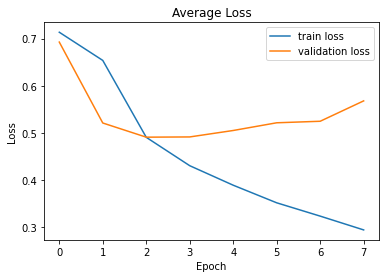

In [35]:
plot_loss(train_history)

## Plot Accuracy against Epochs

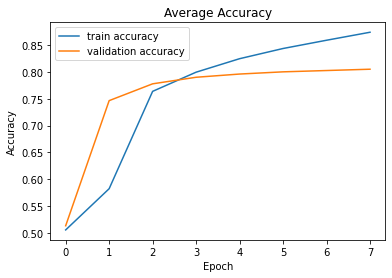

In [36]:
plot_acc(train_history)

From the above plots we can clearly see that the gap between the training and validation losses has decreased by a large margin and best validation accuracy with XLM-RoBERTa model is ~79-80%.

To further evaluate the performance of the XLM-RoBERTa model, we'll generate the confusion matrix and classification report on the validation data.

# Generate Predictions on Test Data

Once we are satisfied with our model's performance, we can get test-data predictions for submission.

In [50]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights('/kaggle/working/T5_best_checkpoint.hdf5')

In [51]:
model.evaluate(test_input, test_labels)

121/121 [==============================] - 6s 26ms/step - loss: 0.5759 - accuracy: 0.7084


[0.5758801102638245, 0.708376407623291]